<a href="https://colab.research.google.com/github/Chubbyman2/Seq2Seq-Translator/blob/main/English_to_Japanese_Translator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A basic Seq2Seq model which utilizes a transformer architecture trained on a dataset of English-to-Japanese phrases.

In [1]:
import os, sys

from keras.models import Model
from keras.layers import Embedding, Dense, GRU, Input, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 64
EPOCHS = 20
NUM_SENTENCES = 30000
MAX_SENTENCE_LENGTH = 50
MAX_NUM_WORDS = 30000
EMBEDDING_SIZE = 100

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
input_sentences = []
output_sentences = []
output_sentences_inputs = []

sentence_count = 0
for line in open(r"/content/gdrive/My Drive/jpn.txt", encoding="utf-8"):
  sentence_count += 1

  # We'll only train it on 30000 phrases
  # Can be adjusted for overfitting
  if sentence_count > NUM_SENTENCES:
    break
  
  if "\t" not in line:
    continue

  input_sentence, output, credits = line.rstrip().split("\t")

  # We need two copies of the translated sentence
  # One with the <EOS> token, and the other with <SOS> token
  
  output_sentence = output + " <EOS>"
  output_sentence_input = "<SOS> " + output
  
  input_sentences.append(input_sentence)
  output_sentences.append(output_sentence)
  output_sentences_inputs.append(output_sentence_input)

print(input_sentences[0:10])
print(output_sentences[0:10])
print(output_sentences_inputs[0:10])

['Go.', 'Go.', 'Hi.', 'Hi.', 'Hi.', 'Hi.', 'Run.', 'Run.', 'Who?', 'Wow!']
['行け。 <EOS>', '行きなさい。 <EOS>', 'こんにちは。 <EOS>', 'もしもし。 <EOS>', 'やっほー。 <EOS>', 'こんにちは！ <EOS>', '走れ。 <EOS>', '走って！ <EOS>', '誰？ <EOS>', 'すごい！ <EOS>']
['<SOS> 行け。', '<SOS> 行きなさい。', '<SOS> こんにちは。', '<SOS> もしもし。', '<SOS> やっほー。', '<SOS> こんにちは！', '<SOS> 走れ。', '<SOS> 走って！', '<SOS> 誰？', '<SOS> すごい！']


In [5]:
print(len(input_sentences))
print(len(output_sentences))
print(len(output_sentences_inputs))

30000
30000
30000


**Tokenization and Padding**

Tokenize the sentences, pad all of them to be the same length as the longest sentence.

In [6]:
# Tokenizer divides sentence into a list of words
# Then converts words in list to integers
input_tokenizer = Tokenizer(num_words = MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_sequences = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print(f"Total unique words in the input: {len(word2idx_inputs)}")

max_input_len = max(len(sentence) for sentence in input_integer_sequences)
print(f"Length of longest input sentence: {max_input_len}")
print(input_integer_sequences[0:10])

Total unique words in the input: 5742
Length of longest input sentence: 9
[[32], [32], [1055], [1055], [1055], [1055], [306], [306], [104], [1219]]


In [7]:
# Tokenize output sentences
# You can see, on average, Japanese sentences are longer and contain more words
output_tokenizer = Tokenizer(num_words = MAX_NUM_WORDS, filters="")
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_sequences = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_sequences = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print(f"Total unique words in the output: {len(word2idx_outputs)}")

num_word_in_output = len(word2idx_outputs) + 1
max_output_len = max(len(sentence) for sentence in output_integer_sequences)
print(f"Length of longest output sentence: {max_output_len}")

Total unique words in the output: 24629
Length of longest output sentence: 6


In [8]:
# Pad the encoder input sentences for LSTM
# LSTM requires fixed-length vectors
encoder_input_sequences = pad_sequences(input_integer_sequences, maxlen = max_input_len)
print(encoder_input_sequences.shape)

# Max length input sentence is 8 words
# Adds seven 0's to the one-word sentence
print(encoder_input_sequences[10])
print(input_sentences[10])

(30000, 9)
[   0    0    0    0    0    0    0    0 1219]
Wow!


In [9]:
print(word2idx_inputs["wow"])

1219


In [10]:
# Pad the decoder inputs
decoder_input_sequences = pad_sequences(output_input_integer_sequences, 
                                        maxlen = max_output_len,
                                        padding = "post")
print(decoder_input_sequences.shape)
print(decoder_input_sequences[10])
print(output_sentences_inputs[10])

(30000, 6)
[   2 3835    0    0    0    0]
<SOS> ワォ！


In [11]:
print(word2idx_outputs["<sos>"])
print(word2idx_outputs["ワォ！"])

2
3835


Note that the encoder sequences are padded at the front because the output is based on the words at the end of a sentence.

For the decoder, processing starts at the start, so the end is padded.

**Word Embeddings**

Instead of using integer representation, word embeddings use vectors to represent words.

Word embeddings capture not just the uniqueness of each word, but also its relationship with other words.

This model uses GloVe word embeddings for English sentences and custom word embeddings for the Japanese sentences.

In [12]:
# The process is similar to creating a dictionary of words for integer representation
# but you use vectors instead of integers

from numpy import array, asarray, zeros

embeddings_dictionary = dict()

glove = open(r"/content/gdrive/My Drive/glove.6B.100d.txt", encoding="utf-8")

for line in glove:
  records = line.split()
  word = records[0]
  vector_dims = asarray(records[1:], dtype="float32")
  embeddings_dictionary[word] = vector_dims

glove.close()

In [13]:
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = zeros((num_words, EMBEDDING_SIZE))

for word, idx in word2idx_inputs.items():
  embedding_vector = embeddings_dictionary.get(word)
  if embedding_vector is not None:
    embedding_matrix[idx] = embedding_vector

print(embeddings_dictionary["wow"])

[ 3.3134e-02  3.9436e-01  7.1448e-01 -1.1337e+00 -7.2332e-01 -3.8481e-01
  5.0780e-01 -1.4907e-01  6.6017e-01 -1.0201e-01  9.6231e-01  1.1387e-03
 -1.3263e-01  4.5797e-02  2.7135e-01 -3.2550e-01 -3.9210e-01  6.5267e-01
 -2.4488e-01  6.0425e-01  4.6606e-01  2.0726e-01 -4.5639e-01 -4.7955e-01
  3.5442e-01  1.3614e+00  6.4953e-02  5.8670e-01  3.8000e-01 -6.9888e-01
 -9.8310e-03  4.4655e-01  3.2409e-01  7.0773e-01 -1.6529e-01  1.4208e-01
 -1.0592e-01  3.4966e-01  4.9768e-01 -1.3657e+00  5.9729e-02  8.9261e-01
 -5.1973e-02 -2.3988e-01 -2.6148e-01 -4.6569e-01  3.8102e-01 -2.2734e-02
  6.7690e-02 -5.2129e-01 -1.0081e+00  3.2135e-01  1.3263e-02 -3.2060e-01
 -1.2772e+00 -9.8548e-01  5.2983e-01 -6.2298e-02  2.2495e-01 -2.6118e-03
 -6.1793e-01  9.9997e-01 -1.0703e+00  2.0964e-01  2.2643e-01  4.3646e-01
  3.7288e-01  4.4264e-01  1.9080e-01  2.0068e-01  9.2300e-01 -4.9012e-02
 -1.2524e-01 -4.6946e-01  4.9879e-02  7.7502e-01  7.5118e-01 -6.8137e-01
  6.9687e-01 -7.6334e-01  1.3828e-01 -7.7210e-01  3

Note that the rows in the embedding matrix represent the corresponding word embeddings from the GloVe word embedding dictionary.


The word embedding matrix will be used to create the model's embedding layer.

In [14]:
print(embedding_matrix[word2idx_inputs["wow"]])

[ 3.31339985e-02  3.94360006e-01  7.14479983e-01 -1.13370001e+00
 -7.23320007e-01 -3.84810001e-01  5.07799983e-01 -1.49069995e-01
  6.60170019e-01 -1.02009997e-01  9.62310016e-01  1.13870006e-03
 -1.32630005e-01  4.57970016e-02  2.71349996e-01 -3.25500011e-01
 -3.92100006e-01  6.52670026e-01 -2.44880006e-01  6.04250014e-01
  4.66060013e-01  2.07259998e-01 -4.56389993e-01 -4.79550004e-01
  3.54420006e-01  1.36140001e+00  6.49529994e-02  5.86700022e-01
  3.79999995e-01 -6.98880017e-01 -9.83100012e-03  4.46550012e-01
  3.24090004e-01  7.07729995e-01 -1.65289998e-01  1.42079994e-01
 -1.05920002e-01  3.49660009e-01  4.97680008e-01 -1.36570001e+00
  5.97289987e-02  8.92610013e-01 -5.19730002e-02 -2.39879996e-01
 -2.61480004e-01 -4.65689987e-01  3.81020010e-01 -2.27339994e-02
  6.76899999e-02 -5.21290004e-01 -1.00810003e+00  3.21350008e-01
  1.32630002e-02 -3.20600003e-01 -1.27719998e+00 -9.85480011e-01
  5.29829979e-01 -6.22979999e-02  2.24950001e-01 -2.61180010e-03
 -6.17929995e-01  9.99970

**The Model**

In [15]:
# Empty output array with correct shape
# Shape: (num of inputs, length of output sentence, number of words in output)
decoder_targets_one_hot = np.zeros((
    len(input_sentences),
    max_output_len,
    num_word_in_output),
    dtype="float32")

decoder_targets_one_hot.shape

(30000, 6, 24630)

In [16]:
decoder_output_sequences = pad_sequences(output_integer_sequences, maxlen=max_output_len, padding='post')
for i, d in enumerate(decoder_output_sequences):
  for t, word in enumerate(d):
    decoder_targets_one_hot[i, t, word] = 1

In [17]:
# Use the embedding matrix to create the embedding layer
embedding_layer = Embedding(num_words, 
                            EMBEDDING_SIZE, 
                            weights=[embedding_matrix], 
                            input_length=max_input_len)

In [18]:
# Encoder
encoder_inputs_placeholder = Input(shape=(max_input_len, ))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(256, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

In [19]:
# Decoder
decoder_inputs_placeholder = Input(shape=(max_output_len, ))

decoder_embedding = Embedding(num_word_in_output, 256)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

In [20]:
# Final Dense layer predicts decoder outputs
decoder_dense = Dense(num_word_in_output, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

In [21]:
# Compile
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [22]:
# Fit
translator = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1
)

Epoch 1/20
422/422 [==============================] - 27s 64ms/step - loss: 1.8411 - accuracy: 0.8186 - val_loss: 1.6973 - val_accuracy: 0.8332
Epoch 2/20
422/422 [==============================] - 26s 63ms/step - loss: 1.6858 - accuracy: 0.8333 - val_loss: 1.7069 - val_accuracy: 0.8332
Epoch 3/20
422/422 [==============================] - 26s 63ms/step - loss: 1.6755 - accuracy: 0.8333 - val_loss: 1.7190 - val_accuracy: 0.8332
Epoch 4/20
422/422 [==============================] - 26s 63ms/step - loss: 1.6572 - accuracy: 0.8333 - val_loss: 1.7354 - val_accuracy: 0.8332
Epoch 5/20
422/422 [==============================] - 27s 63ms/step - loss: 1.6422 - accuracy: 0.8334 - val_loss: 1.7488 - val_accuracy: 0.8332
Epoch 6/20
422/422 [==============================] - 26s 62ms/step - loss: 1.6238 - accuracy: 0.8336 - val_loss: 1.7503 - val_accuracy: 0.8333
Epoch 7/20
422/422 [==============================] - 26s 63ms/step - loss: 1.6091 - accuracy: 0.8338 - val_loss: 1.7655 - val_accuracy:

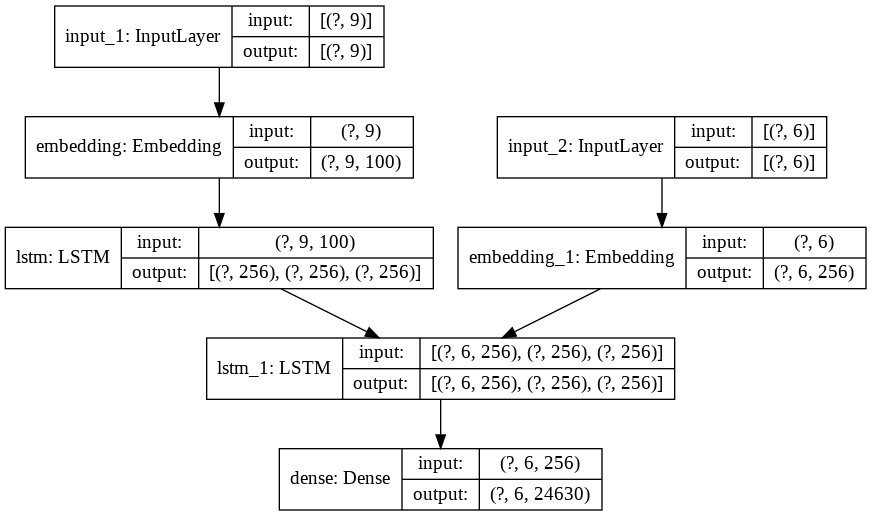

In [23]:
# Visualize the model
# ? = None
from keras.utils import plot_model
plot_model(model, to_file="model_plot4a.png", show_shapes=True, show_layer_names=True)

**Modifying Model for Predictions**

During training, the full output sequence is available, and the model is trained on these inputs and outputs.

However, when making actual predictions, the decoder outputs have a probability of being correct.

As such, the model must be modified to reflect this.

In [34]:
# Encoder is the same
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

In [35]:
# But now we need the decoder hidden and cell states
decoder_state_input_h = Input(shape=(256, ))
decoder_state_input_c = Input(shape=(256, ))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

In [36]:
# Now there will only be one decoder input at each time step
decoder_inputs_single = Input(shape=(1, ))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [37]:
# Placeholder for decoder outputs
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

In [38]:
# Pass decoder output through dense layer
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [39]:
# Define the overall model
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

Notice now that the input is only 1 word at a time, instead of the max_input_len 9-word sentence before.

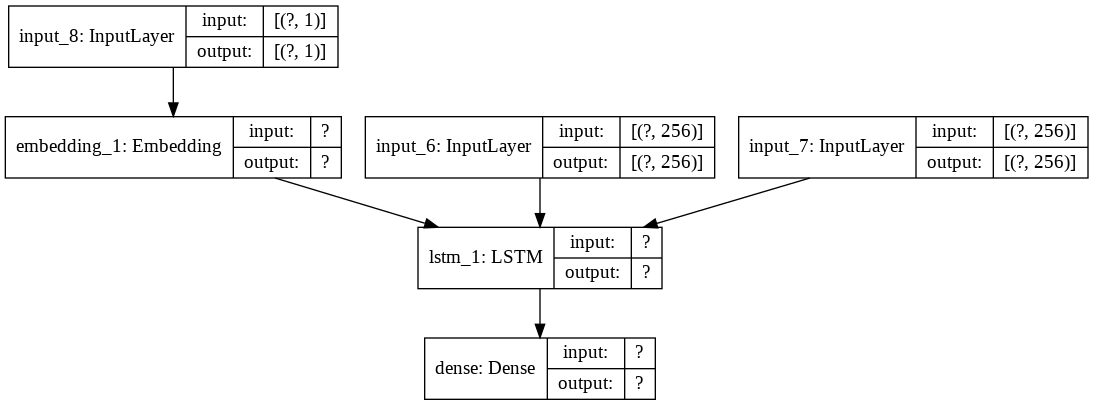

In [40]:
# Visualize
plot_model(decoder_model, to_file="model_plot_dec.png", show_shapes=True, show_layer_names=True)

**Make Predictions**

In [41]:
# Create dictionaries for inputs and outputs (English and Japanese)
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [42]:
# Function that takes a padded English sentence (integer form) 
# Returns it translated into Japanese
def translate(input_sequence):
  states_value = encoder_model.predict(input_sequence)
  target_sequence = np.zeros((1, 1))
  target_sequence[0, 0] = word2idx_outputs["<sos>"]
  eos = word2idx_outputs["<eos>"] # Index of <eos> to indicate end of translation
  output_sentence = []

  for i in range(max_output_len):
    output_tokens, h, c = decoder_model.predict([target_sequence] + states_value)
    idx = np.argmax(output_tokens[0, 0, :])

    if eos == idx:
      break
    
    word = ""

    if idx > 0:
      word = idx2word_target[idx]
      output_sentence.append(word)

    target_sequence[0, 0] = idx
    states_value = [h, c]

  return " ".join(output_sentence)

In [104]:
# Translate 10 random sentences from the dataset
import random

k = 0
for k in range(10):
  i = np.random.choice(len(input_sentences))
  input_sequence = encoder_input_sequences[i:i+1]
  translation = translate(input_sequence)
  print("Input: " + input_sentences[i])
  print("Translation: " + translation)
  print("Actual Translation: " + output_sentences[i].replace(" <EOS>", ""))
  print()
  k += 1

Input: Tom is a buddy of mine.
Translation: トムは私の友人です。
Actual Translation: トムは私の友人です。

Input: That's why we got divorced.
Translation: 誰も死ななかった。
Actual Translation: そういうわけで、私たち離婚したんです。

Input: He kept singing.
Translation: 彼は歌いつづけた。
Actual Translation: 彼は歌いつづけた。

Input: Tom loves Australia.
Translation: トムはいません。
Actual Translation: トムはオーストラリアが大好きだ。

Input: I'm no liar.
Translation: 超腹減った。
Actual Translation: 私、嘘つきじゃないもん。

Input: Tom is right behind me.
Translation: トムはフランス語が上手い。
Actual Translation: トムは私のすぐ後ろにいます。

Input: Let's try again.
Translation: もう一回やってみよう。
Actual Translation: もう一回やってみよう。

Input: I did it.
Translation: そろそろおいとましなければなりません。
Actual Translation: やってやった。

Input: Let me know.
Translation: お前には関係ない。
Actual Translation: ご一報ください。

Input: Close the door, please.
Translation: ドアを閉めて下さい。
Actual Translation: ドアを閉めて下さい。

